In [24]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator
from qiskit_nature.second_q.algorithms import GroundStateEigensolver, QEOM
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit import *
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity, Statevector, Operator, Pauli, SparsePauliOp
from qiskit import Aer
from qiskit.primitives import Estimator
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import TwoLocal, PauliEvolutionGate
from qiskit.algorithms import TimeEvolutionProblem, RealTimeEvolver, RealEvolver, SciPyRealEvolver, VarQRTE
from qiskit.algorithms.time_evolvers import TrotterQRTE
from qiskit.circuit import Parameter

Dihydrogen Molecule (Electronic Hamiltonian):

In [25]:
# Prepare a Dihydrogen Molecule within its second_q_op structure:

h2_driver = PySCFDriver(
    atom = "H 0 0 0; H 0 0 0.735",
    basis = "sto3g",
    charge = 0,
    spin = 0,
    unit = DistanceUnit.ANGSTROM,
)

# Create Problem instance for dihydrogen molecule:

diHydro_prob = h2_driver.run()
print(diHydro_prob)

In [27]:
# Generate the Electronic Hamiltonian for Dihydrogen:

h2_Hamiltonian = diHydro_prob.hamiltonian
coefficients = h2_Hamiltonian.electronic_integrals
print(coefficients.alpha)

Polynomial Tensor
 "+-":
[[-1.25633907e+00 -1.37083854e-17]
 [-6.07732712e-17 -4.71896007e-01]]
 "++--":
[[[[6.75710155e-01 1.69253442e-16]
   [1.56722377e-16 1.80931200e-01]]

  [[4.84650299e-17 1.80931200e-01]
   [6.64581730e-01 3.79897400e-16]]]


 [[[1.01440795e-16 6.64581730e-01]
   [1.80931200e-01 4.71502663e-17]]

  [[1.80931200e-01 3.78920172e-16]
   [6.59828421e-17 6.98573723e-01]]]]


In [28]:
# Apply second-quantization transformation to Electronic Hamiltonian:

sq_h2_op = h2_Hamiltonian.second_q_op()
print(sq_h2_op)

# This Second-Quantized Electronic Hamiltonian does NOT contain the nuclei repulsive/attractive terms!

Fermionic Operator
number spin orbitals=4, number terms=36
  -1.25633907300325 * ( +_0 -_0 )
+ -0.47189600728114184 * ( +_1 -_1 )
+ -1.25633907300325 * ( +_2 -_2 )
+ -0.47189600728114184 * ( +_3 -_3 )
+ 0.33785507740175813 * ( +_0 +_0 -_0 -_0 )
+ 0.09046559989211568 * ( +_0 +_0 -_1 -_1 )
+ 0.09046559989211564 * ( +_0 +_1 -_0 -_1 )
+ 0.33229086512764827 * ( +_0 +_1 -_1 -_0 )
+ 0.33785507740175813 * ( +_0 +_2 -_2 -_0 )
+ 0.09046559989211568 * ( +_0 +_2 -_3 -_1 )
+ 0.09046559989211564 * ( +_0 +_3 -_2 -_1 )
+ 0.33229086512764827 * ( +_0 +_3 -_3 -_0 )
+ 0.3322908651276482 * ( +_1 +_0 -_0 -_1 )
+ 0.09046559989211574 * ( +_1 +_0 -_1 -_0 )
+ 0.09046559989211565 * ( +_1 +_1 -_0 -_0 )
+ 0.3492868613660089 * ( +_1 +_1 -_1 -_1 )
+ 0.3322908651276482 * ( +_1 +_2 -_2 -_1 )
+ 0.09046559989211574 * ( +_1 +_2 -_3 -_0 )
+ 0.09046559989211565 * ( +_1 +_3 -_2 -_0 )
+ 0.3492868613660089 * ( +_1 +_3 -_3 -_1 )
+ 0.33785507740175813 * ( +_2 +_0 -_0 -_2 )
+ 0.09046559989211568 * ( +_2 +_0 -_1 -_3 )
+ 0.0904655

In [66]:
# Set up Jordan-Wigner Mapper/Transformer to bring Second Quantized Hamiltonian into qubit space:

jw_map = JordanWignerMapper()

# Apply mapper to Second Quantized Electronic Hamiltonian:

qubit_h2_Ham = jw_map.map(sq_h2_op)
print(qubit_h2_Ham)
#print(qubit_h2_Ham[0])

#2 * qubit_h2_Ham

-0.8105479805373275 * IIII
+ 0.1721839326191556 * IIIZ
- 0.2257534922240239 * IIZI
+ 0.17218393261915554 * IZII
- 0.2257534922240239 * ZIII
+ 0.12091263261776629 * IIZZ
+ 0.16892753870087907 * IZIZ
+ 0.04523279994605784 * YYYY
+ 0.04523279994605784 * XXYY
+ 0.04523279994605784 * YYXX
+ 0.04523279994605784 * XXXX
+ 0.16614543256382414 * ZIIZ
+ 0.16614543256382414 * IZZI
+ 0.17464343068300445 * ZIZI
+ 0.12091263261776629 * ZZII


PauliSumOp(SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIZZ', 'IZIZ', 'YYYY', 'XXYY', 'YYXX', 'XXXX', 'ZIIZ', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[-1.62109596+0.j,  0.34436787+0.j, -0.45150698+0.j,  0.34436787+0.j,
 -0.45150698+0.j,  0.24182527+0.j,  0.33785508+0.j,  0.0904656 +0.j,
  0.0904656 +0.j,  0.0904656 +0.j,  0.0904656 +0.j,  0.33229087+0.j,
  0.33229087+0.j,  0.34928686+0.j,  0.24182527+0.j]), coeff=1.0)

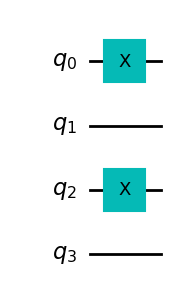

In [30]:
# Obtain the initial state from which to apply the time evolution of the converted Hamiltonian:

initial_state = HartreeFock(diHydro_prob.num_spatial_orbitals, diHydro_prob.num_particles, jw_map,)

# Draw the initial state to evolve:

initial_state.draw('mpl')

In [33]:
# Partition each qubit_h2_Ham list object into separate list of exponentiated summands:

exp_summand = list()
evo_time_range = np.arange(0, 0.2, 0.01)
evo_time = Parameter('t')

for i in range(0, len(qubit_h2_Ham)):
    exp_summand.append(PauliEvolutionGate(qubit_h2_Ham[i], time=evo_time))

[Instruction(name='PauliEvolution', num_qubits=4, num_clbits=0, params=[Parameter(t)]), Instruction(name='PauliEvolution', num_qubits=4, num_clbits=0, params=[Parameter(t)]), Instruction(name='PauliEvolution', num_qubits=4, num_clbits=0, params=[Parameter(t)]), Instruction(name='PauliEvolution', num_qubits=4, num_clbits=0, params=[Parameter(t)]), Instruction(name='PauliEvolution', num_qubits=4, num_clbits=0, params=[Parameter(t)]), Instruction(name='PauliEvolution', num_qubits=4, num_clbits=0, params=[Parameter(t)]), Instruction(name='PauliEvolution', num_qubits=4, num_clbits=0, params=[Parameter(t)]), Instruction(name='PauliEvolution', num_qubits=4, num_clbits=0, params=[Parameter(t)]), Instruction(name='PauliEvolution', num_qubits=4, num_clbits=0, params=[Parameter(t)]), Instruction(name='PauliEvolution', num_qubits=4, num_clbits=0, params=[Parameter(t)]), Instruction(name='PauliEvolution', num_qubits=4, num_clbits=0, params=[Parameter(t)]), Instruction(name='PauliEvolution', num_qub

In [48]:
# Obtain a reverse order of "exp_summand" for the purposes of constructing a symmetric integrator:

exp_summand_rev = list()

for i in range(len(exp_summand) - 1, -1, -1):
    exp_summand_rev.append(exp_summand[i])

In [49]:
# Generate an appropriate Integrator using scheme presented by Childs and Wiebe:

#chi = 2 # Integer value for which the "order" of the symmetric operator-valued S function can be created.

S_1 = exp_summand + exp_summand_rev # Concatenate the two lists of exponentials to form the chi-one symmetric integrator.


In [67]:
# Construct appropriate Multi-Product Formula as presented in Eq. 14 of Childs and Wiebe article (Richardson Extrapolation):



In [ ]:
'''# Experiment: Recursive Symmetric Integrator definition via placement'''

In [ ]:
'''def S_chi_calc(s_p, t):

    return 0'''

In [51]:
'''# Construct a function that generates the appropriate recursively-defined symmetric integrator:

S_chi = list()

def sym_int_chi(chi_step, t):

    #S_chi_step = list()

    #term_1 = list() # (S_(x-1) * (s_(x_1) * t))**2
    #term_2 = list() # S_(x_1) * ((1 - 4*s_(x-1)) * t)

    chi_temp = chi_step - 1

    s_p = 1 / (4 - 4**(1/(2*(chi_temp) + 1))) if chi_temp > 1 else 0 # Assign analytic value to s_p if chi is greater than 1. If not, 0.

    #S_chi_minus = sym_int_chi(chi_step - 1, )

    S_chi = S_1 if (s_p == 0) else ( [(s_p * t * x)**2 for x in sym_int_chi(chi_temp, t)] + [])

    #for i in range 


    
    #S_1 if (chi_step == 1) else sym_int_chi(chi_step - 1, )

    return S_chi

    #return S_1 if (chi_minus == 1) else S_chi_step

'''
